In [25]:
%%capture
!pip install -U numpy==1.23.1

In [26]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification, load_iris, load_breast_cancer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

## Линейная регрессия

Строя модели машинного обучения мы фактически пытаемся найти функциональную зависимость между данными и целевой переменной.

Один из видов такой зависимости является линейная зависимость

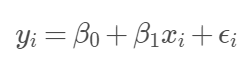

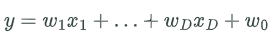

### Task - age of Abalone

Find out the age of Abalone from physical measurements

Rings - value + 1.5 gives age in years (eg. 4 = 5.5 years)

In [27]:
data = pd.read_csv('abalone.data.txt', header=None)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'hucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.head()

,sex,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Работа с категориальными признаками

Sex (M: Male, F: Female, I: Infant)

#### Label Encoding

Применяется:

*   если признак является ординальным, т.е. значения связаны отношением порядка
*   в tree-based моделях


In [28]:
le = LabelEncoder()
le.fit_transform(data['sex'])

array([2, 2, 0, ..., 2, 0, 2])

#### One-Hot Encoding

Применяется:

*   в non-tree-based моделях
*   если у принака невысокая кардинальность



In [29]:
res = pd.get_dummies(data['sex'], prefix='sex', drop_first=True)
res.head()

,sex_I,sex_M
0,0,1
1,0,1
2,0,0
3,0,1
4,1,0


In [30]:
data = pd.concat([data, res], axis=1).drop(columns='sex')
data.head()

,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0


### Мультиколлинеарность

Мультиколлинеарность — наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели. При этом различают полную коллинеарность, которая означает наличие функциональной (тождественной) линейной зависимости и частичную или просто мультиколлинеарность — наличие сильной корреляции между факторами.

Проблемы:

*   Мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату
*   Оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.



In [31]:
corrs = data.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
upper_tri

,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings,sex_I,sex_M
length,NaN,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720,-0.551465,0.236543
diameter,NaN,NaN,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660,-0.564315,0.240376
height,NaN,NaN,NaN,0.819221,0.774972,0.798319,0.817338,0.557467,-0.518552,0.215459
whole_weight,NaN,NaN,NaN,NaN,0.969405,0.966375,0.955355,0.540390,-0.557592,0.252038
hucked_weight,NaN,NaN,NaN,NaN,NaN,0.931961,0.882617,0.420884,-0.521842,0.251793
viscera_weight,NaN,NaN,NaN,NaN,NaN,NaN,0.907656,0.503819,-0.556081,0.242194
shell_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627574,-0.546953,0.235391
rings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.436063,0.181831
sex_I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.522541
sex_M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


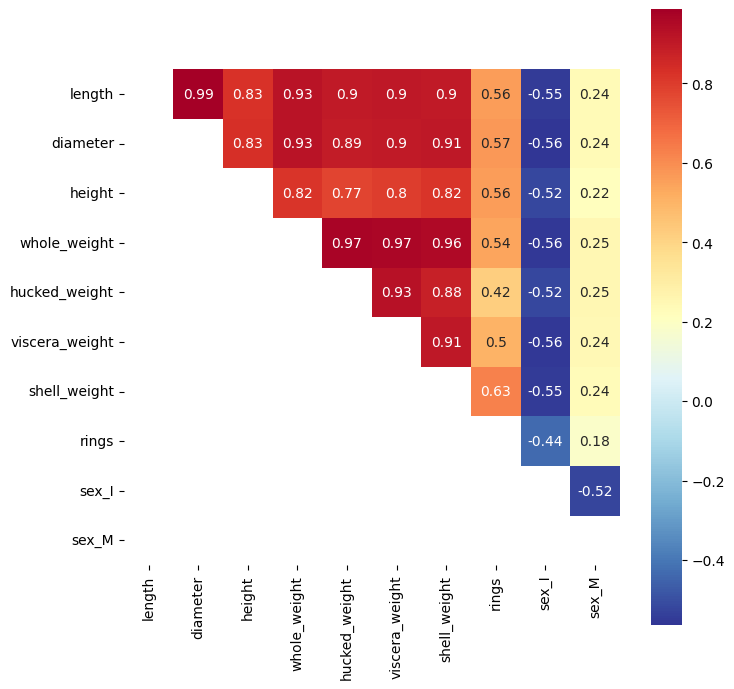

In [32]:
plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True);

In [33]:
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
cols_to_drop

['diameter', 'hucked_weight', 'viscera_weight', 'shell_weight']

In [34]:
cutted_data = data.drop(columns=cols_to_drop)
cutted_data.head()

,length,height,whole_weight,rings,sex_I,sex_M
0,0.455,0.095,0.5140,15,0,1
1,0.350,0.090,0.2255,7,0,1
2,0.530,0.135,0.6770,9,0,0
3,0.440,0.125,0.5160,10,0,1
4,0.330,0.080,0.2050,7,1,0


### Train-test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    cutted_data.drop(columns='rings'),
    cutted_data['rings'],
    random_state=2023,
    test_size=0.3
)

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

In [37]:
print(f'RMSE: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE: 2.5041378689818625


### Масштабирование

Линейные модели обучения эффективны только на признаках, которые имеют одинаковый масштаб. Поэтому масштабирование признаков это неотъемлемая часть подготовки данных перед применением методов машинного обучения.

**Нормализация**: нормализованный набор данных всегда будет иметь значения в диапазоне от 0 до 1.

**Стандартизация**: стандартизированный набор данных будет иметь среднее значение 0 и стандартное отклонение 1

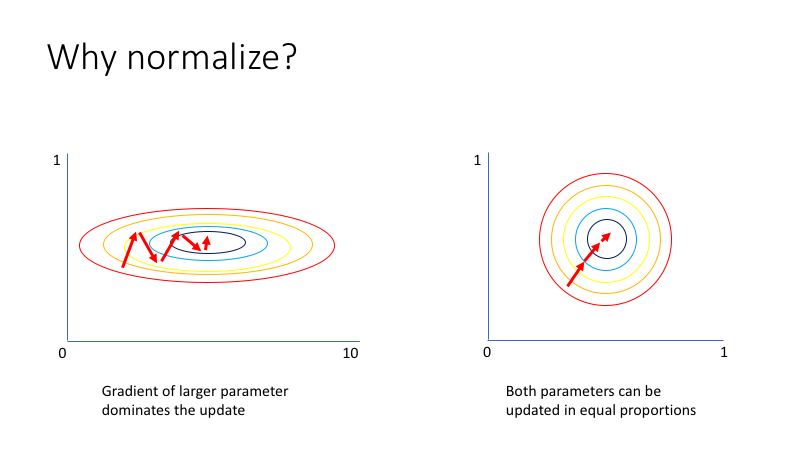

- Более быстрая сходимость алгоритма
- Масштабирование при использовании моделей с регуляризацией позволит штрафовать все признаки одинаково
- Без нормализации "вес" признака представляет собой изменение выхода на единицу изменения в предикторе

 Не существует жесткого правила, которое подскажет, когда нормализовать или стандартизировать данные.

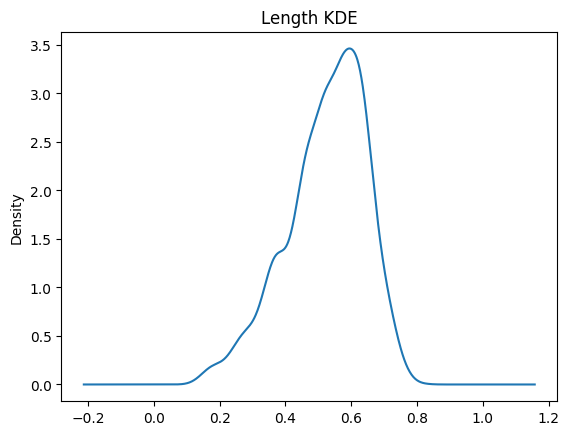

In [38]:
X_train['length'].plot.kde(title='Length KDE');

In [39]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

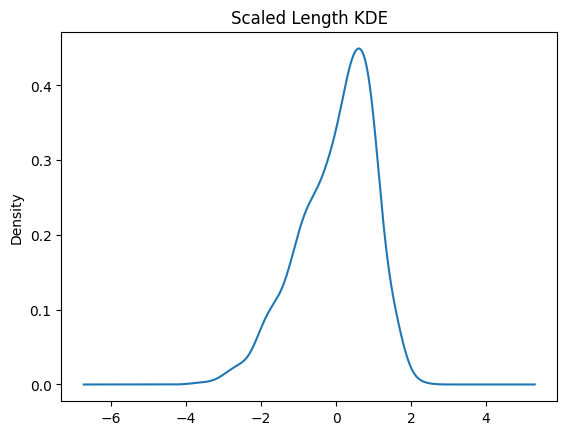

In [40]:
X_test_scaled['length'].plot.kde(title='Scaled Length KDE');

### Refit

In [41]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_preds_lr = lr.predict(X_test_scaled)

In [42]:
print(f'RMSE: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE: 2.5041378689818625


### Интерпретация

Если переменные нормализованы, мы можем интерпретировать веса в линейных моделях как важность этой переменной в прогнозируемом результате.

In [43]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

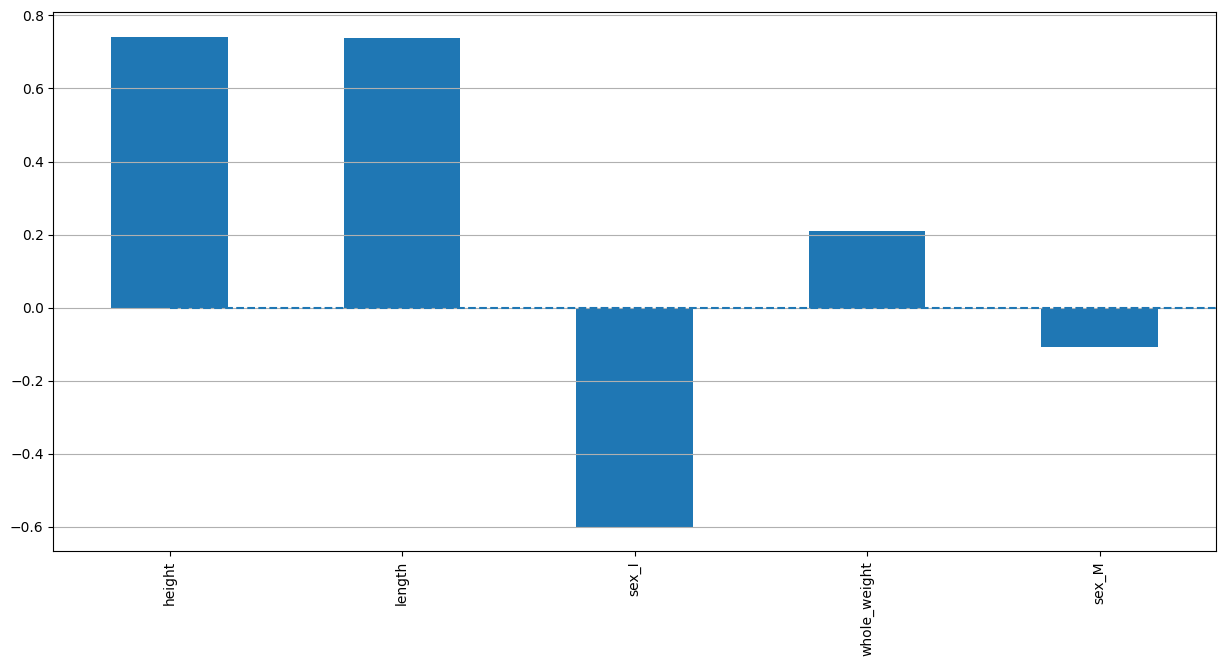

In [44]:
plotCoefficients(lr, X_train_scaled.columns)

## Линейная регрессия с регуляризацией

Для борьбы с мультиколлинеарностью и переобучением можно использовать регуляризацию - добавление дополнительных ограничений на веса признаков внутри алгоритма

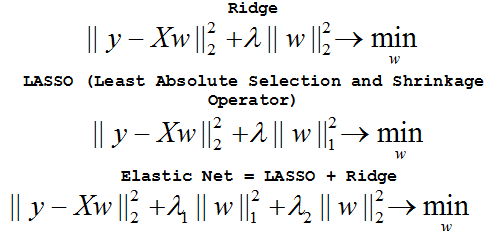

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='rings'),
    data['rings'],
    random_state=2023,
    test_size=0.3
)

In [46]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test)

print(f'RMSE Ridge: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE Ridge: 2.1520038451622883


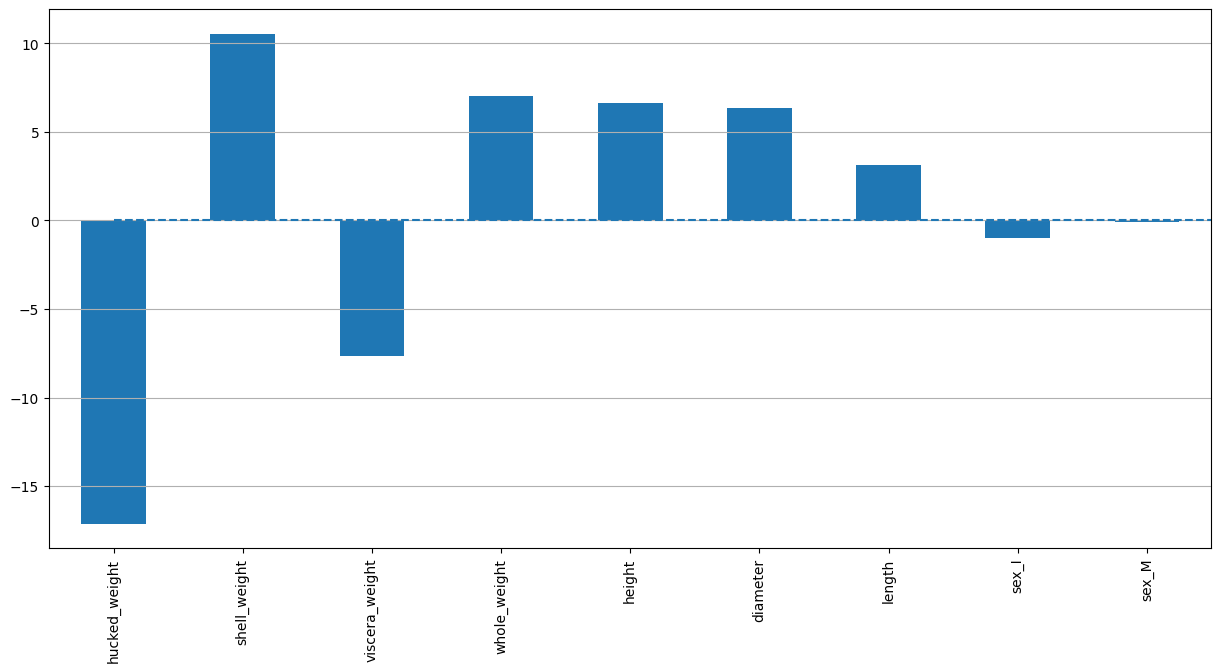

In [47]:
plotCoefficients(ridge, X_train.columns)

## Метод k-ближайших соседей (kNN)

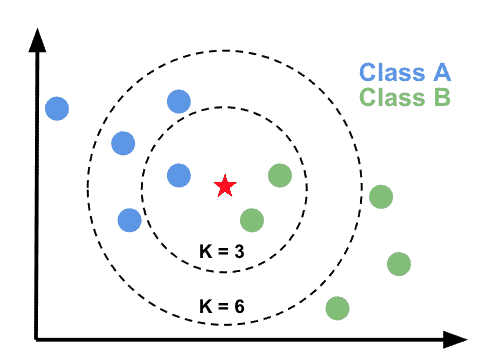

Перед применением необходима нормализация

#### Breast cancer

weights:

`uniform`: все точки взвешиваются одинаково

`distance`: вес обратен расстоянию: более близкие точки имеют большее "влияние"

In [48]:
X, y =  load_breast_cancer(return_X_y=True, as_frame=True)
y = 1 - y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.3)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_preds_knn = knn.predict(X_test)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       110
           1       0.95      0.92      0.93        61

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



#### Visualization

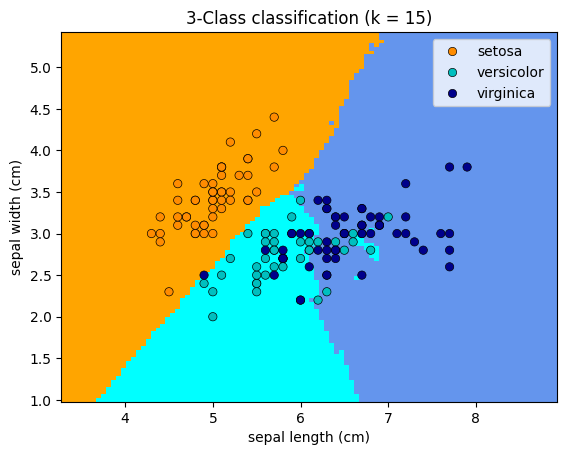

In [49]:
n_neighbors = 15

iris = load_iris()

X = iris.data[:, :2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

clf = KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X, y)

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel=iris.feature_names[0],
    ylabel=iris.feature_names[1],
    shading="auto",
)

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=iris.target_names[y],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(f"3-Class classification (k = {n_neighbors})")

plt.show()

## Деревья решений

Дерево решений предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил

In [50]:
iris = load_iris()
X, y = iris.data, iris.target
clf = DecisionTreeClassifier()
clf = clf.fit(X, y)

In [51]:
y_preds = clf.predict(X)
print(classification_report(y, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [52]:
import graphviz

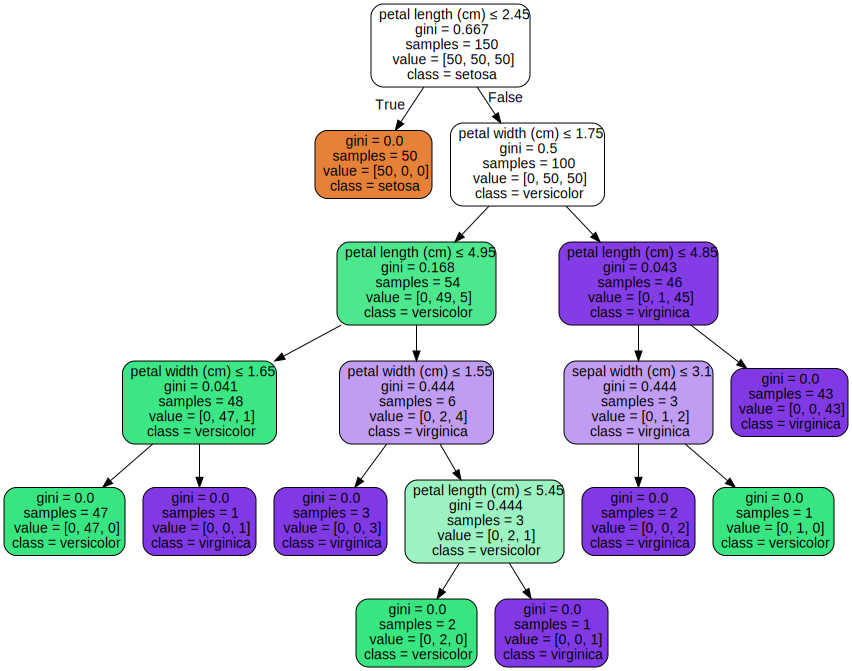

In [53]:
dot_data = export_graphviz(
  clf, out_file=None,
  feature_names=iris.feature_names,
  class_names=iris.target_names,
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(dot_data)
graph

Деревья легко переобучаются

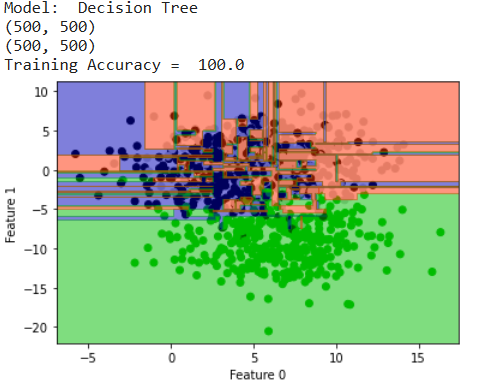